In [47]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [48]:
cd /content/gdrive/MyDrive/new_nlp/Datasets/GCDC_rerelease

/content/gdrive/MyDrive/new_nlp/Datasets/GCDC_rerelease


In [49]:
ls

Clinton_test.csv    Enron_test.csv       lstm_binary_min_sim_yahoo.sav  Yahoo_train.csv
Clinton_train.csv   Enron_train.csv      new_train.csv                  Yelp_test.csv
combined_test.csv   filtered_tokens.pkl  word_to_index.pkl              Yelp_train.csv
combined_train.csv  index_to_word.pkl    Yahoo_test.csv


In [50]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
import torchtext
from collections import Counter
import numpy as np
import pandas as pd
import pickle


In [51]:

class TextDataTokenizer:
    def __init__(self, file_path, min_word_freq=5):
        self.file_path = file_path
        self.min_word_freq = min_word_freq

    def preprocess_text_data(self):
        # Load the data from the CSV file
        data = pd.read_csv(self.file_path)

        # Tokenize the text data using SpaCy
        tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
        tokens = [tokenizer(text) for text in data['text'].tolist()]

        # Count the frequency of each token
        word_freq_counter = Counter()
        for line in tokens:
            word_freq_counter.update(line)

        # Filter tokens based on minimum frequency
        filtered_tokens = [[token for token in line if word_freq_counter[token] >= self.min_word_freq] for line in tokens]

        # Create mappings between tokens and indices
        word_to_index = {word: idx + 1 for idx, (word, freq) in enumerate(word_freq_counter.items())}
        index_to_word = {idx + 1: word for idx, (word, freq) in enumerate(word_freq_counter.items())}

        return filtered_tokens, word_to_index, index_to_word

    def save_preprocessed_data(self, filtered_tokens, word_to_index, index_to_word):
        # Save the preprocessed data and mappings to pickle files
        with open('filtered_tokens.pkl', 'wb') as f:
            pickle.dump(filtered_tokens, f)
        with open('word_to_index.pkl', 'wb') as f:
            pickle.dump(word_to_index, f)
        with open('index_to_word.pkl', 'wb') as f:
            pickle.dump(index_to_word, f)






In [52]:
import pandas as pd
df = pd.read_csv('Yelp_train.csv')
df_head = df.head()

columns_list = df.columns.tolist()
columns_list

['text_id',
 'subject',
 'text',
 'ratingA1',
 'ratingA2',
 'ratingA3',
 'labelA',
 'ratingM1',
 'ratingM2',
 'ratingM3',
 'ratingM4',
 'ratingM5',
 'labelM']

In [53]:
df_head

,text_id,subject,text,ratingA1,ratingA2,ratingA3,labelA,ratingM1,ratingM2,ratingM3,ratingM4,ratingM5,labelM
0,FUYQ99EUHg2TOHMMTy7cFQ,Seasons Buffet,Most months this buffet at the Silverton has o...,3,2,3,3,3,2,3,2,1,2
1,8Mkhxopb8jzL748V-oCVKg,The Cleaning Authority - Phoenix,"Awful, I should have looked at yelp. I receiv...",2,3,2,3,2,3,2,3,2,3
2,db7i0JVq9s_AKVvOoHBNxQ,Bad Owl Coffee,"I don't know how I found this place on Yelp, b...",2,3,3,3,3,3,2,2,3,3
3,9HebYLRstsuqti5_7P0hEg,Moe's Southwest Grill,"I love Moe's. So much better than Chipotle, IM...",2,3,3,3,2,3,3,2,3,3
4,7KgfshQrZ9O9iMIABtm59Q,Nirvana the Flavors of India,"Visiting from the US, I was looking for a some...",3,2,2,3,2,3,3,1,2,2


In [54]:
# For Yelp_train.csv
train_tokenizer = TextDataTokenizer('Yelp_train.csv')
filtered_tokens_train, word_to_index_train, index_to_word_train = train_tokenizer.preprocess_text_data()
train_tokenizer.save_preprocessed_data(filtered_tokens_train, word_to_index_train, index_to_word_train)



In [55]:
# For Yelp_test.csv
test_tokenizer = TextDataTokenizer('Yelp_test.csv')
filtered_tokens_test, word_to_index_test, index_to_word_test = test_tokenizer.preprocess_text_data()
test_tokenizer.save_preprocessed_data(filtered_tokens_test, word_to_index_test, index_to_word_test)


In [56]:
import matplotlib.pyplot as plt

# Basic Statistics
train_review_lengths = [len(review) for review in filtered_tokens_train]
print(filtered_tokens_train)
print(train_review_lengths)
test_review_lengths = [len(review) for review in filtered_tokens_test]


[['Most', 'months', 'this', 'buffet', 'at', 'the', 'has', 'one', 'day', 'a', 'week', 'they', 'do', 'BOGO', '.', 'For', 'it', "'s", 'BOGO', 'Thursday', '.', 'up', 'for', 'a', 'card', 'at', 'the', "'s", 'club', 'and', 'the', 'day', 'of', 'the', 'BOGO', 'print', 'out', 'a', 'coupon', 'at', 'the', 'and', 'head', 'to', 'the', 'buffet', '.', 'The', 'coupon', 'is', 'only', 'good', 'for', 'that', 'day', '.', '\n\n', 'Also', 'the', 'same', 'day', 'you', 'sign', 'up', 'for', 'the', "'s", 'card', ',', 'play', 'table', 'games', 'and', 'just', '50', 'points', 'and', 'you', 'get', 'another', 'coupon', 'for', 'a', 'free', 'buffet', 'to', 'use', 'anytime', 'you', 'want', '.', '\n\n', 'The', 'buffet', 'is', 'pretty', 'good', 'for', '$', ',', 'then', 'in', 'the', 'BOGO', 'it', "'s", 'only', '$', '5', '/', 'person', '.', 'Ca', "n't", 'beat', 'that', 'deal', ',', 'as', 'you', 'ca', "n't", 'even', 'get', 'full', 'of', 'of', '$', '5', 'at', 'a', 'fast', 'food', 'place', '.', ' ', 'There', "'s", 'Mexican', '

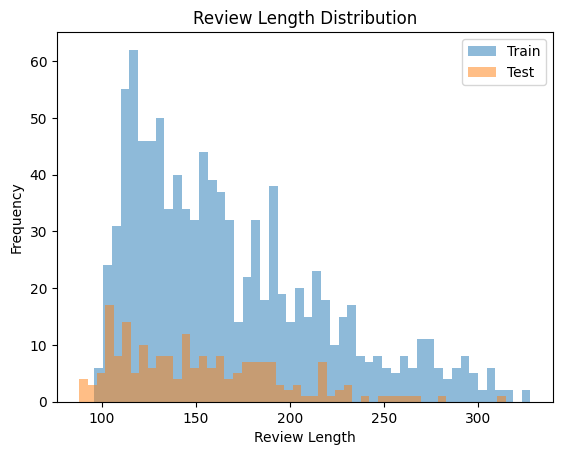

In [57]:
# Visualize Review Length Distribution
plt.hist(train_review_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(test_review_lengths, bins=50, alpha=0.5, label='Test')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.legend()
plt.show()


In [58]:

print("Train Data Statistics:")
print("Number of Samples:", len(filtered_tokens_train))
print("Average Review Length:", sum(train_review_lengths) / len(train_review_lengths))

print("\nTest Data Statistics:")
print("Number of Samples:", len(filtered_tokens_test))
print("Average Review Length:", sum(test_review_lengths) / len(test_review_lengths))



Train Data Statistics:
Number of Samples: 1000
Average Review Length: 167.808

Test Data Statistics:
Number of Samples: 200
Average Review Length: 152.135


In [59]:

# Word Frequency Analysis
word_freq_train = Counter(word for review in filtered_tokens_train for word in review)
word_freq_test = Counter(word for review in filtered_tokens_test for word in review)

# Visualize Word Frequency
common_words_train = word_freq_train.most_common(20)
common_words_test = word_freq_test.most_common(20)

print("Top 20 Common Words in Train Data:", common_words_train)
print("Top 20 Common Words in Test Data:", common_words_test)


Top 20 Common Words in Train Data: [('.', 8843), ('the', 6599), (',', 5447), ('and', 5135), ('I', 4788), ('a', 4099), ('to', 3986), ('was', 2859), (' ', 2324), ('of', 2266), ('it', 1958), ('for', 1867), ('is', 1850), ('in', 1714), ('!', 1482), ('that', 1375), ('The', 1348), ('with', 1310), ('my', 1264), ('you', 1261)]
Top 20 Common Words in Test Data: [('.', 1703), ('the', 1290), (',', 1156), ('and', 1065), ('I', 889), ('a', 820), ('to', 790), ('was', 574), ('of', 461), ('it', 420), (' ', 378), ('for', 372), ('is', 368), ('in', 324), ('!', 320), ('that', 271), ('with', 267), ('The', 252), ("n't", 236), ('\n\n', 232)]


In [60]:
# For Yelp_train.csv
print("Training Data:")
print("Number of filtered tokens:", len(filtered_tokens_train))
print("Example filtered tokens:", filtered_tokens_train[:5])
print("Number of unique words:", len(word_to_index_train))
print("Example word to index mapping:", {k: v for k, v in list(word_to_index_train.items())[:5]})
print("Example index to word mapping:", {k: v for k, v in list(index_to_word_train.items())[:5]})
print()



Training Data:
Number of filtered tokens: 1000
Example filtered tokens: [['Most', 'months', 'this', 'buffet', 'at', 'the', 'has', 'one', 'day', 'a', 'week', 'they', 'do', 'BOGO', '.', 'For', 'it', "'s", 'BOGO', 'Thursday', '.', 'up', 'for', 'a', 'card', 'at', 'the', "'s", 'club', 'and', 'the', 'day', 'of', 'the', 'BOGO', 'print', 'out', 'a', 'coupon', 'at', 'the', 'and', 'head', 'to', 'the', 'buffet', '.', 'The', 'coupon', 'is', 'only', 'good', 'for', 'that', 'day', '.', '\n\n', 'Also', 'the', 'same', 'day', 'you', 'sign', 'up', 'for', 'the', "'s", 'card', ',', 'play', 'table', 'games', 'and', 'just', '50', 'points', 'and', 'you', 'get', 'another', 'coupon', 'for', 'a', 'free', 'buffet', 'to', 'use', 'anytime', 'you', 'want', '.', '\n\n', 'The', 'buffet', 'is', 'pretty', 'good', 'for', '$', ',', 'then', 'in', 'the', 'BOGO', 'it', "'s", 'only', '$', '5', '/', 'person', '.', 'Ca', "n't", 'beat', 'that', 'deal', ',', 'as', 'you', 'ca', "n't", 'even', 'get', 'full', 'of', 'of', '$', '5', '

In [61]:
# For Yelp_test.csv
print("Test Data:")
print("Number of filtered tokens:", len(filtered_tokens_test))
print("Example filtered tokens:", filtered_tokens_test[:5])
print("Number of unique words:", len(word_to_index_test))
print("Example word to index mapping:", {k: v for k, v in list(word_to_index_test.items())[:5]})
print("Example index to word mapping:", {k: v for k, v in list(index_to_word_test.items())[:5]})


Test Data:
Number of filtered tokens: 200
Example filtered tokens: [['little', 'place', 'to', 'find', 'if', 'you', 'have', "n't", 'been', 'there', 'before', '.', ' ', 'with', 'no', 'menu', 'except', 'what', 'is', 'on', 'the', 'so', 'it', "'s", 'a', 'little', 'hard', 'to', 'make', 'a', 'on', 'what', 'you', 'want', 'when', 'they', 'ask', 'you', 'at', 'the', 'counter', 'for', 'your', 'order', '.', '\n\n', 'this', 'visit', 'I', 'had', 'the', 'and', 'my', 'lunch', 'had', 'the', '.', 'My', 'lunch', 'really', 'enjoyed', 'her', 'dish', '.', ' ', 'However', ',', 'the', 'just', 'was', "n't", 'very', 'good', '.', 'The', 'was', 'very', 'small', 'of', 'beef', 'that', 'flavor', 'and', '.', ' ', 'The', 'was', 'a', '.', '\n\n', 'Overall', ',', 'the', 'service', 'was', 'good', 'and', 'the', 'food', 'just', '..'], ['I', 'love', 'this', 'place', '.', 'seriously', 'their', 'food', 'when', 'I', 'go', 'a', 'week', 'without', 'it', '.', 'I', 'believe', 'I', "'ve", 'ordered', 'the', '"', 'me', 'to', 'the', '"